In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [3]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res

HouseData = LoadHouse()
NofAlgorithms = 5
# AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
AlgorithmNames=['IPFP', 'RRWM', 'SM', 'FGM', 'OursPW']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        [G, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        # G2 = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        [Gvis, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        G.SetVerbose(False)
        
        # Our-PW
        res = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(res.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = res.Time
        Obj[4][ImageI] = res.Value
        #end Our-PW
        
        # IPFP
        resIPFP = eng.runIPFP(FName, nargout=3)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(resIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = resIPFP[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resIPFP[1][0][i])
        Obj[0][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA
        
        # RRWM
        resRRWM = eng.runRRWM(FName, nargout=3)
        AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(resRRWM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][1][ImageI] = resRRWM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWM[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWM
        
        # SpectralMatching
        # resSM = eng.runIPFP(nargout=3)
        resSM = eng.runSM(FName, nargout=3)
        AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resSM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][2][ImageI] = resSM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resSM[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        #end SpectralMatching
        
        # FGM
        resFGM = eng.runSM(FName, nargout=3)
        #resFGM = eng.runFGM(FName, nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resFGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resFGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resFGM[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end FGM
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

 Start baseline: 10


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.965347 Running Time 0.006403 Obj 0.966510
RRWM Accuracy 0.985809 Running Time 0.031378 Obj 0.989347
SM Accuracy 0.961056 Running Time 0.020440 Obj 0.969110
FGM Accuracy 0.961056 Running Time 0.019945 Obj 0.969110
OursPW Accuracy 1.000000 Running Time 0.008063 Obj 1.000000
××××××××××××××××××××
 Start baseline: 20


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.739927 Running Time 0.007541 Obj 0.737649
RRWM Accuracy 0.913187 Running Time 0.042053 Obj 0.920933
SM Accuracy 0.852747 Running Time 0.023819 Obj 0.859560
FGM Accuracy 0.852747 Running Time 0.023386 Obj 0.859560
OursPW Accuracy 1.000000 Running Time 0.014204 Obj 1.000000
××××××××××××××××××××
 Start baseline: 30


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.481893 Running Time 0.007382 Obj 0.503780
RRWM Accuracy 0.708642 Running Time 0.075039 Obj 0.723118
SM Accuracy 0.668724 Running Time 0.025340 Obj 0.673367
FGM Accuracy 0.668724 Running Time 0.025048 Obj 0.673367
OursPW Accuracy 1.000000 Running Time 0.019009 Obj 1.000000
××××××××××××××××××××
 Start baseline: 40


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.324883 Running Time 0.006627 Obj 0.397910
RRWM Accuracy 0.467136 Running Time 0.059962 Obj 0.515705
SM Accuracy 0.488263 Running Time 0.025123 Obj 0.522731
FGM Accuracy 0.488263 Running Time 0.025293 Obj 0.522731
OursPW Accuracy 1.000000 Running Time 0.039248 Obj 1.000000
××××××××××××××××××××
 Start baseline: 50


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.243716 Running Time 0.007135 Obj 0.357593
RRWM Accuracy 0.369399 Running Time 0.061059 Obj 0.450283
SM Accuracy 0.378142 Running Time 0.025006 Obj 0.445509
FGM Accuracy 0.378142 Running Time 0.024743 Obj 0.445509
OursPW Accuracy 1.000000 Running Time 0.052058 Obj 1.000000
××××××××××××××××××××
 Start baseline: 60


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.173203 Running Time 0.006928 Obj 0.331701
RRWM Accuracy 0.204575 Running Time 0.051024 Obj 0.349446
SM Accuracy 0.251634 Running Time 0.025907 Obj 0.373071
FGM Accuracy 0.251634 Running Time 0.024920 Obj 0.373071
OursPW Accuracy 1.000000 Running Time 0.080798 Obj 1.000000
××××××××××××××××××××
 Start baseline: 70


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.118699 Running Time 0.007383 Obj 0.325954
RRWM Accuracy 0.151220 Running Time 0.060771 Obj 0.337651
SM Accuracy 0.199187 Running Time 0.026000 Obj 0.356801
FGM Accuracy 0.199187 Running Time 0.026381 Obj 0.356801
OursPW Accuracy 1.000000 Running Time 0.109479 Obj 1.000000
××××××××××××××××××××
 Start baseline: 80


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.130108 Running Time 0.007129 Obj 0.312263
RRWM Accuracy 0.139785 Running Time 0.049398 Obj 0.326495
SM Accuracy 0.193548 Running Time 0.026605 Obj 0.368057
FGM Accuracy 0.193548 Running Time 0.026996 Obj 0.368057
OursPW Accuracy 1.000000 Running Time 0.162403 Obj 1.000000
××××××××××××××××××××
 Start baseline: 90


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.152381 Running Time 0.006395 Obj 0.353620
RRWM Accuracy 0.163492 Running Time 0.049050 Obj 0.367001
SM Accuracy 0.139683 Running Time 0.026379 Obj 0.355519
FGM Accuracy 0.139683 Running Time 0.025417 Obj 0.355519
OursPW Accuracy 0.996825 Running Time 0.204520 Obj 1.000000
××××××××××××××××××××
 Start baseline: 100


FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:398: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

IPFP Accuracy 0.096970 Running Time 0.006774 Obj 0.346477
RRWM Accuracy 0.115152 Running Time 0.045544 Obj 0.356283
SM Accuracy 0.087879 Running Time 0.026682 Obj 0.345666
FGM Accuracy 0.087879 Running Time 0.025786 Obj 0.345666
OursPW Accuracy 0.978788 Running Time 0.249560 Obj 1.000000
××××××××××××××××××××


/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


array([ 0.96534653,  0.73992674,  0.481893  ,  0.32488263,  0.24371585,
        0.17320261,  0.11869919,  0.13010753,  0.15238095,  0.0969697 ])

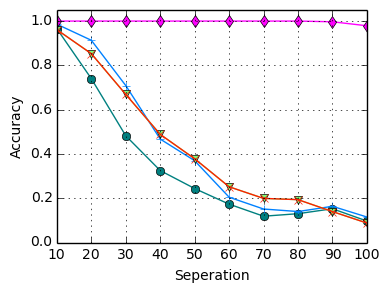

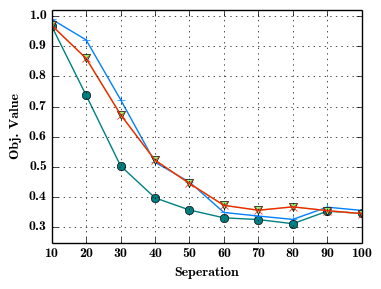

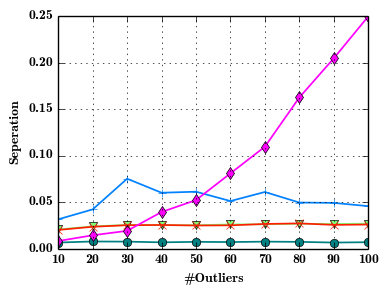

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline


Colors = [[ 0.        ,  0.5        , 0.5        ,  1.        ],
          #[ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
         # [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          #[ 0.5       ,  1.        ,  0.17273877,  1.        ],
          #[ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ]];
Seq = [0, 1, 2, 3, 4]
AlgorithmNames=['IPFP', 'RRWM', 'SM', 'FGM', 'OursPW']
Markers = ['o', '+', 'v', 'x', 'd']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/EdgesOnly/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/EdgesOnly/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'OursPW'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('results/EdgesOnly/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/EdgesOnly/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [16]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
[G,FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)

BaBIter=1, GUB = 100000000000000000000.000000, GLB = -100000000000000000000.000000, Gap = 2.00, Time=0.0027
